In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

folder_path = 'C:/Users/Matth/Documents/Leiden University/IDL/assignments/A1/A1_data_75'
image_file_name = '/images.npy'
label_file_name = '/labels.npy'

images = np.load(folder_path+image_file_name)
images = np.expand_dims(images, axis=-1)
labels = np.load(folder_path+label_file_name)

images, labels = shuffle_in_unison(images,labels)


In [41]:
def shuffle_in_unison(a, b):
    if len(a) != len(b):
        raise ValueError('Two arrays are incompatible for shuffling in unison')
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [42]:
def train_test_valid_split(a,b,train=0.8,test=0.1,valid=0.1,shuffle=True,check_data = True):
    if len(a) != len(b):
        raise ValueError('Two arrays are incompatible for splitting in unison')
    total_percentage = train + test + valid
    if total_percentage != 1:
        raise ValueError(f'''Data will not be split correctly \n 
        Total percentage of data used :{total_percentage*100}% \n 
        Training = {train*100}%, testing = {test*100}%, validation = {valid*100}%''')
    if shuffle == True:
        a, b = shuffle_in_unison(a,b)
    
    train_idx = int(len(a)*train)
    test_idx = train_idx+int(len(a)*test)
    valid_idx = len(a)
    train_x = a[:train_idx]
    test_x = a[train_idx:test_idx]
    valid_x = a[test_idx:]
    train_y = b[:train_idx]
    test_y = b[train_idx:test_idx]
    valid_y = b[test_idx:]

    
    if check_data:
        check_len_match = len(train_x) + len(test_x) + len(valid_x)
        print(f'Size of train, test and valid: {len(train_x)},{len(test_x)},{len(valid_x)}')
        if check_len_match == len(a):
            print('yippee')
        else:
            print('no:(')
    
    return train_x, train_y, test_x, test_y, valid_x, valid_y

Size of train, test and valid: 14400,1800,1800
yippee


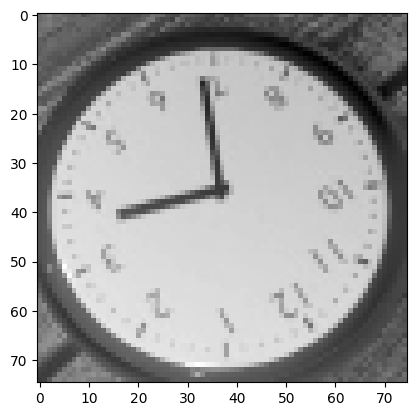

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [57]:
from tensorflow.keras.utils import to_categorical
train_x, train_y, test_x, test_y, valid_x, valid_y = train_test_valid_split(images, labels)
train_y = to_categorical(train_y[:,0], num_classes=12)
valid_y = to_categorical(valid_y[:,0], num_classes=12)
check_random_sample(train_x,train_y)

In [44]:
def check_random_sample(a,b):
    rand_int=np.random.randint(0,len(a))
    plt.imshow(a[rand_int],cmap='gray')
    plt.show()
    print(b[rand_int])

In [9]:
# Can use data augmentation to increase the training data set size ie by concatentating a dataset that contatins all the flipped images
# Could also augmentent the data so that all images are alligned in the same direction to remove noise but this may make the model perform worse generally

In [70]:
class CNN(Sequential):
    def __init__(self,input_image_shape=(75,75),hour_classes=12,minute_dimensions=60):
        super().__init__()
        self.add(Conv2D(filters = 32, 
                        kernel_size=(20,20), 
                        strides= (1,1),
                        padding= 'same', 
                        activation= 'relu',
                        input_shape= input_image_shape,
                        kernel_initializer= 'random_normal'))
        # self.add(MaxPooling2D(pool_size=(2,2), strides= (1,1),
        #                       padding= 'valid', data_format= None))
        self.add(Conv2D(filters = 64, 
                        kernel_size=(3,3), 
                        strides= (1,1),
                        padding= 'same', 
                        activation= 'relu',
                        kernel_initializer= 'random_normal'))
        # self.add(MaxPooling2D(pool_size=(2,2), strides= (1,1),
                              # padding= 'valid', data_format= None))
        self.add(Flatten())
        self.add(Dense(128,activation='relu'))
        self.add(Dense(128,activation='relu'))
        self.add(Dense(hour_classes, activation= 'softmax'))
        
        self.compile(optimizer= tf.keras.optimizers.Adam(0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
        

In [49]:
train_input_dim = (75, 75, 1)

In [47]:
num_hour_classes = len(set(train_y[:,0]))
num_minute_classes = len(set(train_y[:,1]))
print(num_hour_classes,num_minute_classes)

12 60


In [73]:
model = CNN(train_input_dim, num_hour_classes)

# training parameters
EPOCHS = 1
BATCH_SIZE = 64
image_height = 75
image_width = 75
train_dir = "./content/train"
valid_dir = "./content/validation"
model_dir = "./my_model.h5"

In [35]:
import os
import datetime
if os.path.isdir("logs"):
    print('directory exists')
else:
    os.mkdir('./logs')
    os.mkdir('./logs/fit')


directory exists


In [74]:
log_dir="./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
callback_list = [tensorboard_callback]

train_num = train_x.shape[0]
valid_num = valid_x.shape[0]

# start training
model.fit(  train_x,
            train_y,
            epochs=EPOCHS,
            validation_data=(valid_x, valid_y),
            callbacks=callback_list,
            verbose=1
)
model.summary()

# save the whole model
model.save(model_dir)

Epoch 1/50
450/450 [==============================] - 299s 662ms/step - loss: 384.4925 - accuracy: 0.0851 - val_loss: 2.4877 - val_accuracy: 0.0772
Epoch 2/50
450/450 [==============================] - 293s 650ms/step - loss: 2.4852 - accuracy: 0.0882 - val_loss: 2.4892 - val_accuracy: 0.0722
Epoch 3/50
450/450 [==============================] - 300s 666ms/step - loss: 2.4823 - accuracy: 0.0923 - val_loss: 2.4885 - val_accuracy: 0.0717
Epoch 4/50
450/450 [==============================] - 299s 664ms/step - loss: 2.4793 - accuracy: 0.0947 - val_loss: 2.4902 - val_accuracy: 0.0728
Epoch 5/50
450/450 [==============================] - 300s 666ms/step - loss: 2.4771 - accuracy: 0.0939 - val_loss: 2.4909 - val_accuracy: 0.0717
Epoch 6/50
450/450 [==============================] - 303s 673ms/step - loss: 2.4745 - accuracy: 0.0990 - val_loss: 2.4986 - val_accuracy: 0.0700
Epoch 7/50
450/450 [==============================] - 308s 685ms/step - loss: 2.4700 - accuracy: 0.0984 - val_loss: 2.4917


KeyboardInterrupt

